# 10: Ingeniería de Características para Modelamiento

**Propósito:** Este *notebook* carga el `analytical_dataset.parquet` final y crea las *features* dinámicas y de comportamiento avanzadas (como se definen en el plan de investigación) necesarias para el modelamiento predictivo.

**Proceso:**
1.  **Cargar:** Cargar `analytical_dataset.parquet`.
2.  **Crear Features Fundacionales:**
    * Calcular el voto mayoritario de la bancada (Party Line) para cada votación.
    * Calcular la cohesión de la bancada (Índice de Rice) para cada votación.
    * Determinar si el legislador votó "con la bancada" (Booleano).
3.  **Crear Features de Comportamiento (Rolling):**
    * Calcular `disciplina_partidaria_historia` (ventana móvil).
    * Calcular `indice_discolo` (basado en Rice y voto).
4.  **Crear Features de Especialización:**
    * Calcular `entropia_tematica` (basado en *features* `ambito_`).
5.  **Crear Features de Distancia (Opcional - Matriz):**
    * Calcular `distancia_al_ejecutivo` y `centralidad_red`.
6.  **Guardar:** Guardar el *dataset* final listo para el modelo.

**Salidas (Artifacts):**
* `data/03_final/model_ready_dataset.parquet`

In [51]:
import pandas as pd
import numpy as np
import logging
from pathlib import Path
import sys
import json
from sklearn.preprocessing import MultiLabelBinarizer

# --- Configurar Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Importar lógica personalizada de /src ---
sys.path.append('../') 
try:
    # Necesitamos la función de normalizar texto para el merge de colegios
    from src.common_utils import normalize_string
except ImportError as e:
    logging.error(f"ERROR: No se pudo importar desde /src. {e}")
    raise

In [52]:
# --- 1. Configuración de Rutas y Constantes ---
ROOT = Path.cwd().parent
DATA_DIR_FINAL = ROOT / "data" / "03_final"

ANALYTICAL_FILE = DATA_DIR_FINAL / 'analytical_dataset.parquet'

logging.info(f"Directorio Final: {DATA_DIR_FINAL}")

2025-11-18 15:24:49,793 - INFO - Directorio Final: C:\Users\angel\OneDrive\Documents\U\2025-2\Proyecto de Grado\Legislative-Voting-Behavior-Prediction-\data\03_final


In [53]:
df = pd.read_parquet(ANALYTICAL_FILE)
df.head(4)

,votacion_id,fecha_votacion,total_si,total_no,total_abstenciones,total_dispensado,quorum,diputado_id,voto_valor,boletin_id,...,autores_json,materias_str,materias_json,boletin_id_consultado,topic_materia,topic_titulo,topic_materia_id,topic_materia_nombre,topic_titulo_id,topic_titulo_nombre
0,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,800,1,2625-07,...,"[""R\u00edos Santander, Mario""]",PREDIOS URBANOS,"[""PREDIOS URBANOS""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces
1,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,802,1,2625-07,...,"[""R\u00edos Santander, Mario""]",PREDIOS URBANOS,"[""PREDIOS URBANOS""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces
2,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,807,1,2625-07,...,"[""R\u00edos Santander, Mario""]",PREDIOS URBANOS,"[""PREDIOS URBANOS""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces
3,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,806,1,2625-07,...,"[""R\u00edos Santander, Mario""]",PREDIOS URBANOS,"[""PREDIOS URBANOS""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces


In [55]:
df.columns

Index(['votacion_id', 'fecha_votacion', 'total_si', 'total_no',
       'total_abstenciones', 'total_dispensado', 'quorum', 'diputado_id',
       'voto_valor', 'boletin_id', 'periodo', 'partido_id',
       'periodo_fecha_inicio', 'militancia_fecha_inicio',
       'militancia_fecha_termino', 'nombre_completo', 'nombre',
       'apellido_paterno', 'apellido_materno', 'sexo', 'fecha_defuncion',
       'fecha_nacimiento', 'edad_inicio_periodo', 'rango_etario',
       'estado_civil', 'numero_hijos', 'pais_nacimiento', 'ciudad_nacimiento',
       'distrito', 'educacion_nivel', 'universidad', 'universidad_tipo',
       'carrera_primaria', 'carrera_secundaria', 'colegio_merge_key',
       'nombre_padre_raw', 'nombre_madre_raw', 'colegio_raw', 'match_fuzzy',
       'score', 'dependencia_colegio', 'dependencia_etiqueta',
       'antiguedad_partido_anios', 'indice_rice', 'voto_bancada',
       'voto_con_bancada', 'disciplina_partidaria_hist', 'titulo',
       'fecha_ingreso', 'iniciativa', 'camara

In [7]:
df_model = df.copy()[['votacion_id', 'fecha_votacion', 'total_si', 'total_no',
       'total_abstenciones', 'total_dispensado', 'quorum', 'diputado_id',
       'voto_valor', 'boletin_id', 'periodo', 'partido_id',
       'periodo_fecha_inicio', 'militancia_fecha_inicio',
       'militancia_fecha_termino', 'nombre_completo', 'sexo', 'edad_inicio_periodo', 'rango_etario',
       'estado_civil', 'numero_hijos', 'pais_nacimiento', 'ciudad_nacimiento',
       'distrito', 'educacion_nivel', 'universidad', 'universidad_tipo',
       'carrera_primaria', 'carrera_secundaria', 'dependencia_colegio',
       'antiguedad_partido_anios', 'indice_rice', 'voto_bancada',
       'voto_con_bancada', 'disciplina_partidaria_hist', 'fecha_ingreso', 'iniciativa', 'camara_origen', 'etapa', 'topic_materia_id', 'topic_titulo_id']]

In [8]:
import pandas as pd
import numpy as np
import logging
from pathlib import Path
import sys
import plotly.express as px
import pyarrow

# --- Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # (Usaremos esto para el Baseline)

# --- Modelos ---
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# --- Evaluación ---
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
import shap # (pip install shap)
import matplotlib.pyplot as plt

# --- Configurar Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [9]:
logging.info("Preparando datos para el modelo binario...")

# 1. Filtrar abstenciones (voto_valor == 0.5)
df_model = df[df['voto_valor'].isin([0.0, 1.0])].copy()

# 2. Asegurar que el target 'y' sea un entero (0 ó 1)
df_model['voto_valor'] = df_model['voto_valor'].astype(int)

# 3. (Opcional) Revisar el balance de clases
logging.info(f"Balance de clases (Aprueba=1, Rechaza=0):\n{df_model['voto_valor'].value_counts(normalize=True)}")
logging.info(f"Filas de modelo (sin abstenciones): {df_model.shape}")

2025-11-18 10:40:43,600 - INFO - Preparando datos para el modelo binario...
2025-11-18 10:40:45,055 - INFO - Balance de clases (Aprueba=1, Rechaza=0):
voto_valor
1    0.773174
0    0.226826
Name: proportion, dtype: float64
2025-11-18 10:40:45,056 - INFO - Filas de modelo (sin abstenciones): (1830964, 64)


In [37]:
# 1. Target (y)
TARGET = 'voto_valor'

# 2. Features (X)
NUMERIC_FEATURES = [
    'edad_inicio_periodo',
    'disciplina_partidaria_hist',
    'indice_rice',
    'antiguedad_partido_anios',
    'numero_hijos'
]

CATEGORICAL_FEATURES = [
    'partido_id',
    'rango_etario',
    'sexo',
    'educacion_nivel',
    'carrera_primaria',
    'periodo',
    'quorum',
    'pais_nacimiento',
    'ciudad_nacimiento',
    'universidad', 'universidad_tipo',
    'etapa',
    'estado_civil',
    'camara_origen',
    'topic_materia_id',
    'dependencia_colegio',
    'distrito'
]

# (Excluimos 'diputado_id' por ahora para evitar sobreajuste masivo - alta cardinalidad)
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

In [38]:
# 1. Asegurarse de que esté ordenado por fecha
df_model = df_model.sort_values(by='periodo_fecha_inicio')

# 2. Identificar el último período
last_period = df_model['periodo'].unique()[-1]
logging.info(f"Período de Prueba (Hold-out): {last_period}")

# 3. Crear los splits
train_mask = (df_model['periodo'] != last_period)
test_mask = (df_model['periodo'] == last_period)

X_train = df_model.loc[train_mask, FEATURES]
y_train = df_model.loc[train_mask, TARGET]

X_test = df_model.loc[test_mask, FEATURES]
y_test = df_model.loc[test_mask, TARGET]

X_train[NUMERIC_FEATURES] = X_train[NUMERIC_FEATURES].astype(float)
X_test[NUMERIC_FEATURES] = X_test[NUMERIC_FEATURES].astype(float)

# Convertir Int64/Object (con pd.NA) a string
# OneHotEncoder tratará '<NA>' o 'nan' como una categoría más.
X_train[CATEGORICAL_FEATURES] = X_train[CATEGORICAL_FEATURES].astype(str)
X_test[CATEGORICAL_FEATURES] = X_test[CATEGORICAL_FEATURES].astype(str)

logging.info(f"Filas de Entrenamiento (Períodos < {last_period}): {X_train.shape[0]}")
logging.info(f"Filas de Prueba (Período == {last_period}): {X_test.shape[0]}")

2025-11-18 10:55:52,976 - INFO - Período de Prueba (Hold-out): 2022-2026
2025-11-18 10:55:56,148 - INFO - Filas de Entrenamiento (Períodos < 2022-2026): 1363867
2025-11-18 10:55:56,148 - INFO - Filas de Prueba (Período == 2022-2026): 467097


In [39]:
# 1. Crear el transformador numérico
numeric_transformer = StandardScaler()

# 2. Crear el transformador categórico
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Unir en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # (Dejar pasar otras columnas si las hubiera)
)

logging.info("Pipeline de pre-procesamiento creado.")

2025-11-18 10:55:56,155 - INFO - Pipeline de pre-procesamiento creado.


In [40]:
from sklearn.impute import SimpleImputer

# 1. Crear el transformador numérico (AHORA ES UN PIPELINE)
#    Paso 1: Rellenar NaNs con la mediana
#    Paso 2: Escalar los datos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # <-- EL ARREGLO
    ('scaler', StandardScaler())
])

# 2. Crear el transformador categórico (AHORA ES UN PIPELINE)
#    Paso 1: Rellenar NaNs con "missing" (como una categoría nueva)
#    Paso 2: Aplicar OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # <-- EL ARREGLO
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# 3. Unir en un ColumnTransformer (Esta parte no cambia)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

logging.info("Pipeline de pre-procesamiento (con Imputers) creado.")

2025-11-18 10:55:56,165 - INFO - Pipeline de pre-procesamiento (con Imputers) creado.


2025-11-18 11:00:33,904 - INFO - Ratio de balanceo calculado (scale_pos_weight): 0.2692
2025-11-18 11:00:33,905 - INFO - Iniciando entrenamiento del GDB (XGBoost)...
C:\Users\angel\miniconda3\envs\pytorch\Lib\site-packages\xgboost\training.py:199: UserWarning:

[11:00:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


2025-11-18 11:00:49,516 - INFO - ✓ Entrenamiento finalizado.
2025-11-18 11:00:49,517 - INFO - Generando predicciones en Test Set...



   REPORTE DE EVALUACIÓN: XGBoost (GDB)
Accuracy Global: 0.5477

Reporte de Clasificación:
              precision    recall  f1-score   support

 Rechaza (0)       0.34      0.69      0.45    125996
 Aprueba (1)       0.81      0.49      0.61    341101

    accuracy                           0.55    467097
   macro avg       0.57      0.59      0.53    467097
weighted avg       0.68      0.55      0.57    467097



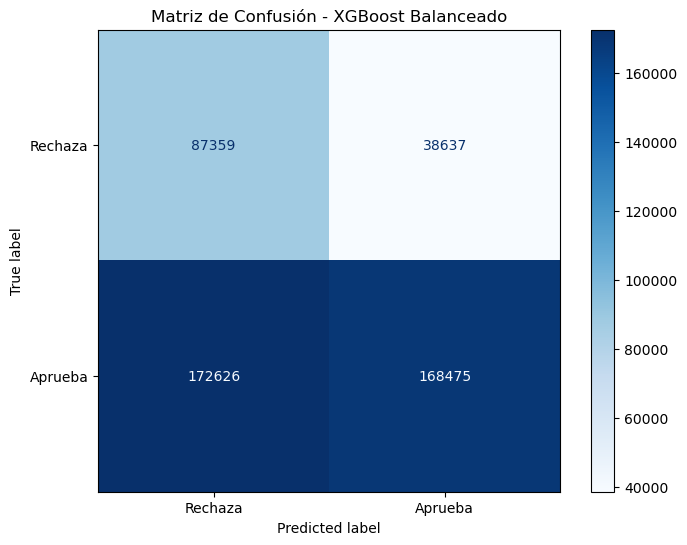

In [42]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging

# --- 1. Cálculo del Ratio de Balanceo (Dinámico) ---
# Esto es crucial: XGBoost necesita saber cuánto "pesa" la clase minoritaria
conteo_clases = y_train.value_counts()
conteo_rechaza = conteo_clases.get(0, 0) # Clase 0 (Minoría usualmente)
conteo_aprueba = conteo_clases.get(1, 1) # Clase 1 (Mayoría)

# Fórmula: Sum(Negativos) / Sum(Positivos)
balance_ratio = conteo_rechaza / conteo_aprueba
logging.info(f"Ratio de balanceo calculado (scale_pos_weight): {balance_ratio:.4f}")

# --- 2. Definición del Pipeline ---
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), # Tu ColumnTransformer definido anteriormente
    ('classifier', xgb.XGBClassifier(
        # Hiperparámetros Base (puedes ajustarlos luego con GridSearch)
        n_estimators=200,           # Cantidad de árboles (iteraciones de boosting)
        learning_rate=0.05,         # Velocidad de aprendizaje (evita overfitting)
        max_depth=6,                # Profundidad de los árboles
        
        # Configuración del Modelo
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=balance_ratio, # <-- ¡LA MAGIA DEL BALANCEO!
        random_state=42,
        n_jobs=-1                   # Usar todos los núcleos del CPU
    ))
])

# --- 3. Entrenamiento ---
logging.info("Iniciando entrenamiento del GDB (XGBoost)...")
pipe_xgb.fit(X_train, y_train)
logging.info("✓ Entrenamiento finalizado.")

# --- 4. Evaluación ---
logging.info("Generando predicciones en Test Set...")
y_pred_xgb = pipe_xgb.predict(X_test)

print("\n" + "="*40)
print("   REPORTE DE EVALUACIÓN: XGBoost (GDB)")
print("="*40)

# Métricas Numéricas
print(f"Accuracy Global: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb, target_names=['Rechaza (0)', 'Aprueba (1)']))

# Visualización: Matriz de Confusión
# (Usamos un gráfico más estético que el print simple)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_xgb, 
    display_labels=['Rechaza', 'Aprueba'], 
    cmap='Blues',
    values_format='d', # Formato entero (sin decimales científicos)
    ax=ax
)
plt.title("Matriz de Confusión - XGBoost Balanceado")
plt.grid(False) # Quitar la grilla para limpieza visual
plt.show()

2025-11-18 11:14:26,556 - INFO - Iniciando análisis de Importancia de Features (Nativo de XGBoost)...
2025-11-18 11:14:26,557 - WARNING - Pivote: Se usará 'feature_importances_' de XGBoost debido a un bug de compatibilidad con SHAP.
2025-11-18 11:14:26,564 - INFO - ✓ Importancia de features calculada.



--- Importancia de Features (Ranking Nativo de XGBoost) ---


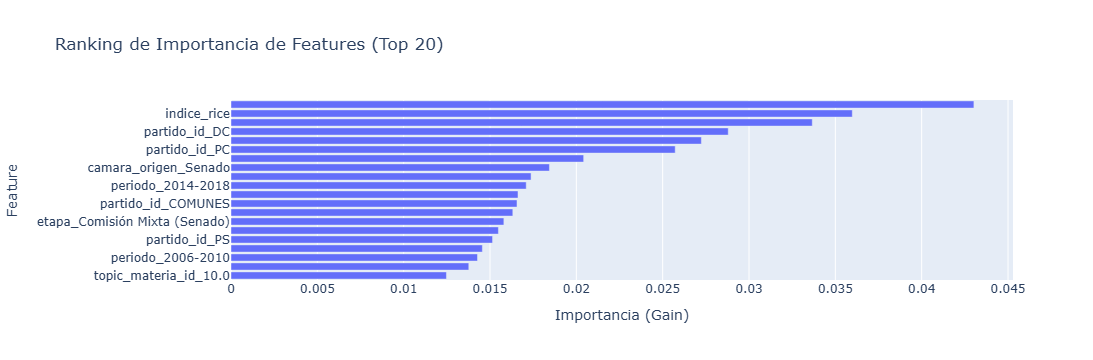

,feature,importance
298,distrito_22,0.043024
2,indice_rice,0.035982
12,partido_id_IND,0.033664
7,partido_id_DC,0.028797
25,partido_id_RD,0.027241
15,partido_id_PC,0.025726
270,topic_materia_id_4.0,0.020424
248,camara_origen_Senado,0.018442
262,topic_materia_id_2.0,0.017378
68,periodo_2014-2018,0.017097


In [43]:
import plotly.express as px # (Asegúrate de tenerlo importado)

logging.info("Iniciando análisis de Importancia de Features (Nativo de XGBoost)...")
logging.warning("Pivote: Se usará 'feature_importances_' de XGBoost debido a un bug de compatibilidad con SHAP.")

# 1. Extraer el clasificador y el preprocesador del pipeline
xgb_model = pipe_xgb.named_steps['classifier']
preprocessor_fitted = pipe_xgb.named_steps['preprocessor']

# 2. Obtener los nombres de las features *después* del OneHotEncoding
try:
    feature_names = preprocessor_fitted.get_feature_names_out()
    feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
except Exception as e:
    logging.error(f"No se pudieron obtener los nombres de las features automáticamente: {e}")
    raise e

# 3. (EL PIVOTE) Obtener la importancia nativa del modelo
#    (Esto es un array de números, uno por cada feature)
importances = xgb_model.feature_importances_

# 4. Crear un DataFrame para mapear nombres a importancia
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

logging.info("✓ Importancia de features calculada.")

# 5. ¡El Gráfico "Pulento"! (Ranking de Features)
print("\n--- Importancia de Features (Ranking Nativo de XGBoost) ---")
# (Mostrar el top 20)
top_20_features = df_importance.head(20).sort_values(by='importance', ascending=True)

fig = px.bar(
    top_20_features,
    x='importance',
    y='feature',
    orientation='h',
    title="Ranking de Importancia de Features (Top 20)",
    labels={'importance': 'Importancia (Gain)', 'feature': 'Feature'}
)
fig.update_layout(yaxis_title="Feature", xaxis_title="Importancia (Gain)")
fig.show()

display(df_importance.head(10))

In [44]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
import logging

# --- 1. Configuración de la Validación Temporal ---
# TimeSeriesSplit asegura que NO miremos el futuro al validar
# n_splits=5 significa que haremos 5 pruebas progresivas en el tiempo
tscv = TimeSeriesSplit(n_splits=5)

# --- 2. Definir el Espacio de Búsqueda (El "Grid") ---
# Aquí definimos qué perillas queremos que el algoritmo mueva.
# Usamos distribuciones (randint, uniform) para que RandomizedSearch explore libremente.

param_dist = {
    # Cantidad de árboles (Más es mejor, pero más lento y puede overfittear)
    'classifier__n_estimators': randint(100, 500),
    
    # Profundidad del árbol (Más profundo = modelo más complejo)
    'classifier__max_depth': randint(3, 10),
    
    # Velocidad de aprendizaje (Menor = más robusto pero requiere más árboles)
    'classifier__learning_rate': uniform(0.01, 0.2), # Entre 0.01 y 0.21
    
    # Submuestreo (Evita overfitting al no usar todos los datos/columnas en cada árbol)
    'classifier__subsample': uniform(0.6, 0.4),      # Entre 0.6 y 1.0
    'classifier__colsample_bytree': uniform(0.6, 0.4), # Entre 0.6 y 1.0
    
    # Peso de la clase positiva (Podemos dejar que varíe un poco alrededor de tu ratio calculado)
    'classifier__scale_pos_weight': [balance_ratio, balance_ratio * 1.2, balance_ratio * 0.8]
}

# --- 3. Configurar la Búsqueda (RandomizedSearchCV) ---
logging.info("Configurando RandomizedSearchCV...")

search = RandomizedSearchCV(
    estimator=pipe_xgb,           # Tu pipeline actual
    param_distributions=param_dist, 
    n_iter=20,                    # Probará 20 combinaciones distintas (Ajusta según tu tiempo)
    scoring='f1',                 # Optimizamos para F1-Score (balance entre precisión y recall)
    cv=tscv,                      # ¡CRÍTICO! Usamos la validación de serie de tiempo
    verbose=1,
    n_jobs=-1,                    # Usar todos los núcleos
    random_state=42
)

# --- 4. Ejecutar la Búsqueda (El proceso pesado) ---
logging.info("Iniciando búsqueda de hiperparámetros (esto puede tardar)...")

# Nota: Usamos X_train y y_train. El search se encargará de dividir internamente.
search.fit(X_train, y_train)

logging.info("✓ Búsqueda finalizada.")

# --- 5. Resultados ---
print("\n" + "="*40)
print("   MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*40)
print(f"Mejor F1-Score (en validación): {search.best_score_:.4f}")
print("\nMejores Parámetros:")
for param, value in search.best_params_.items():
    print(f" - {param}: {value}")

# --- 6. Actualizar el Modelo ---
# El objeto 'search' ahora se comporta como el mejor modelo encontrado
best_model = search.best_estimator_

# Evaluación final en el Test Set (que nunca se tocó durante la búsqueda)
logging.info("Evaluando el mejor modelo en el Test Set final...")
y_pred_opt = best_model.predict(X_test)

print("\n--- Evaluación Final: XGBoost Optimizado ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
print(classification_report(y_test, y_pred_opt, target_names=['Rechaza (0)', 'Aprueba (1)']))

2025-11-18 11:14:35,556 - INFO - Configurando RandomizedSearchCV...
2025-11-18 11:14:35,558 - INFO - Iniciando búsqueda de hiperparámetros (esto puede tardar)...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\angel\miniconda3\envs\pytorch\Lib\site-packages\xgboost\training.py:199: UserWarning:

[11:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


2025-11-18 11:30:58,992 - INFO - ✓ Búsqueda finalizada.
2025-11-18 11:30:58,999 - INFO - Evaluando el mejor modelo en el Test Set final...



   MEJORES HIPERPARÁMETROS ENCONTRADOS
Mejor F1-Score (en validación): 0.8146

Mejores Parámetros:
 - classifier__colsample_bytree: 0.7483273008793065
 - classifier__learning_rate: 0.14376825053272146
 - classifier__max_depth: 7
 - classifier__n_estimators: 198
 - classifier__scale_pos_weight: 0.323090925334465
 - classifier__subsample: 0.9548850970305306

--- Evaluación Final: XGBoost Optimizado ---
Accuracy: 0.6270
              precision    recall  f1-score   support

 Rechaza (0)       0.37      0.55      0.44    125996
 Aprueba (1)       0.80      0.66      0.72    341101

    accuracy                           0.63    467097
   macro avg       0.58      0.60      0.58    467097
weighted avg       0.68      0.63      0.64    467097



In [47]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
import logging

# --- 1. Configuración de la Validación Temporal ---
# TimeSeriesSplit asegura que NO miremos el futuro al validar
# n_splits=5 significa que haremos 5 pruebas progresivas en el tiempo
tscv = TimeSeriesSplit(n_splits=5)

# --- 2. Definir el Espacio de Búsqueda (El "Grid") ---
# Aquí definimos qué perillas queremos que el algoritmo mueva.
# Usamos distribuciones (randint, uniform) para que RandomizedSearch explore libremente.

param_dist = {
    # Cantidad de árboles (Más es mejor, pero más lento y puede overfittear)
    'classifier__n_estimators': randint(100, 500),
    
    # Profundidad del árbol (Más profundo = modelo más complejo)
    'classifier__max_depth': randint(3, 10),
    
    # Velocidad de aprendizaje (Menor = más robusto pero requiere más árboles)
    'classifier__learning_rate': uniform(0.01, 0.2), # Entre 0.01 y 0.21
    
    # Submuestreo (Evita overfitting al no usar todos los datos/columnas en cada árbol)
    'classifier__subsample': uniform(0.6, 0.4),      # Entre 0.6 y 1.0
    'classifier__colsample_bytree': uniform(0.6, 0.4), # Entre 0.6 y 1.0
    
    # Peso de la clase positiva (Podemos dejar que varíe un poco alrededor de tu ratio calculado)
    'classifier__scale_pos_weight': [1.0, balance_ratio, balance_ratio * 0.5]
}

# --- 3. Configurar la Búsqueda (RandomizedSearchCV) ---
logging.info("Configurando RandomizedSearchCV...")

search = RandomizedSearchCV(
    estimator=pipe_xgb,           # Tu pipeline actual
    param_distributions=param_dist, 
    n_iter=30,                    # Probará 20 combinaciones distintas (Ajusta según tu tiempo)
    scoring='accuracy',                 # Optimizamos para F1-Score (balance entre precisión y recall)
    cv=tscv,                      # ¡CRÍTICO! Usamos la validación de serie de tiempo
    verbose=1,
    n_jobs=-1,                    # Usar todos los núcleos
    random_state=42
)

# --- 4. Ejecutar la Búsqueda (El proceso pesado) ---
logging.info("Iniciando búsqueda de hiperparámetros (esto puede tardar)...")

# Nota: Usamos X_train y y_train. El search se encargará de dividir internamente.
search.fit(X_train, y_train)

logging.info("✓ Búsqueda finalizada.")

# --- 5. Resultados ---
print("\n" + "="*40)
print("   MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*40)
print(f"Mejor F1-Score (en validación): {search.best_score_:.4f}")
print("\nMejores Parámetros:")
for param, value in search.best_params_.items():
    print(f" - {param}: {value}")

# --- 6. Actualizar el Modelo ---
# El objeto 'search' ahora se comporta como el mejor modelo encontrado
best_model = search.best_estimator_

# Evaluación final en el Test Set (que nunca se tocó durante la búsqueda)
logging.info("Evaluando el mejor modelo en el Test Set final...")
y_pred_opt = best_model.predict(X_test)

print("\n--- Evaluación Final: XGBoost Optimizado ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
print(classification_report(y_test, y_pred_opt, target_names=['Rechaza (0)', 'Aprueba (1)']))

2025-11-18 12:26:44,862 - INFO - Configurando RandomizedSearchCV...
2025-11-18 12:26:44,863 - INFO - Iniciando búsqueda de hiperparámetros (esto puede tardar)...


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\angel\miniconda3\envs\pytorch\Lib\site-packages\xgboost\training.py:199: UserWarning:

[12:52:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


2025-11-18 12:52:19,595 - INFO - ✓ Búsqueda finalizada.
2025-11-18 12:52:19,616 - INFO - Evaluando el mejor modelo en el Test Set final...



   MEJORES HIPERPARÁMETROS ENCONTRADOS
Mejor F1-Score (en validación): 0.7847

Mejores Parámetros:
 - classifier__colsample_bytree: 0.7783331011414365
 - classifier__learning_rate: 0.02999498316360058
 - classifier__max_depth: 5
 - classifier__n_estimators: 187
 - classifier__scale_pos_weight: 1.0
 - classifier__subsample: 0.8404460046972835

--- Evaluación Final: XGBoost Optimizado ---
Accuracy: 0.7292
              precision    recall  f1-score   support

 Rechaza (0)       0.48      0.06      0.11    125996
 Aprueba (1)       0.74      0.98      0.84    341101

    accuracy                           0.73    467097
   macro avg       0.61      0.52      0.47    467097
weighted avg       0.67      0.73      0.64    467097

